In [1]:
#IMPORTS
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate
from scipy.optimize import curve_fit


In [2]:
#HARDCODED VALUES
R_URANUS = 25559 #at 1bar level (i.e. surface) (equatorial) in km

/tmp/ipykernel_100175/1825026631.py:13: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x - d * x**2)
/tmp/ipykernel_100175/1825026631.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(decay_func, r, spl(r))


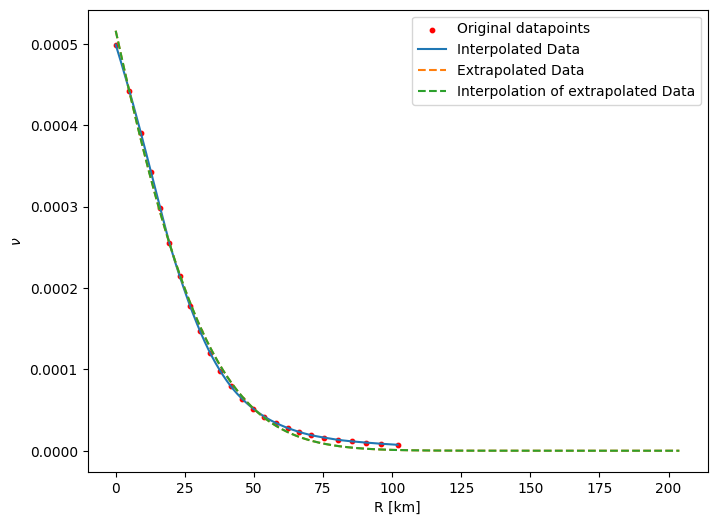

In [3]:
#Atmosphere nu values in 1D, interpolation and extrapolation on atmosphere and above


#generate data for interpolation
data = np.loadtxt("uranus_profile_default.csv", delimiter=',')
R_datapoints = data[:, 1]
nu_datapoints = data[:, 4]
spl = CubicSpline(R_datapoints, nu_datapoints)

r = np.linspace(np.min(R_datapoints), np.max(R_datapoints), 1000)

def decay_func(x, a, b, c, d):
    return a * np.exp(-b * x - d * x**2)

# Fit the curve to find optimal parameters
params, _ = curve_fit(decay_func, r, spl(r))

x_extrap = np.linspace(np.min(R_datapoints), 2*np.max(R_datapoints), 1000)
y_extrap = decay_func(x_extrap, *params)

r2 = np.linspace(np.min(R_datapoints), 2*np.max(R_datapoints), 5000)
spl2 = CubicSpline(x_extrap, y_extrap)

plt.figure(figsize=(8, 6))
plt.scatter(R_datapoints, nu_datapoints, s=10, c='r', label='Original datapoints')
plt.plot(r, spl(r), label='Interpolated Data')
plt.plot(x_extrap, y_extrap, label='Extrapolated Data', linestyle='dashed')
plt.plot(r2, spl2(r2), label='Interpolation of extrapolated Data', linestyle='dashed')

plt.xlabel('R [km]')
plt.ylabel(r'$\nu$')
plt.legend()
plt.show()

def calc_r(s, h):
    '''
    Calculates the distance to the center of the planet.
    Input values:
    s: path variable (-inf initially, 0 when passing the planet, infinity at the end)
    b: impact parameter
    '''
    b = R_URANUS + h
    
    return np.sqrt(s**2 + b**2)


def calc_nu(s, h):

    r = calc_r(s, h)
    h_atm = r - R_URANUS #go back to of atmosphere
    
    if (h_atm > 2*np.max(R_datapoints)):
        return 0

    else:
        return spl2(h_atm)


def calc_los(h):
    '''
    Calculates the line-of-sight integral
    Input values:
    b: Impact parameter
    '''
    return integrate.quad(lambda s: calc_nu(s, h), -np.inf, np.inf)[0]


calc_los_vectorized = np.vectorize(calc_los)


# Explanation how to use this script

### Use calc_los_vectorized and input an array of h values (height of the atmosphere, in km)
### It then returns the array for the change in the optical path (in km)

## Visualizes the Change in optical path for difference heights of the atmosphere in 1d

/tmp/ipykernel_100175/1825026631.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda s: calc_nu(s, h), -np.inf, np.inf)[0]


Text(0, 0.5, 'Difference in optical path [km]')

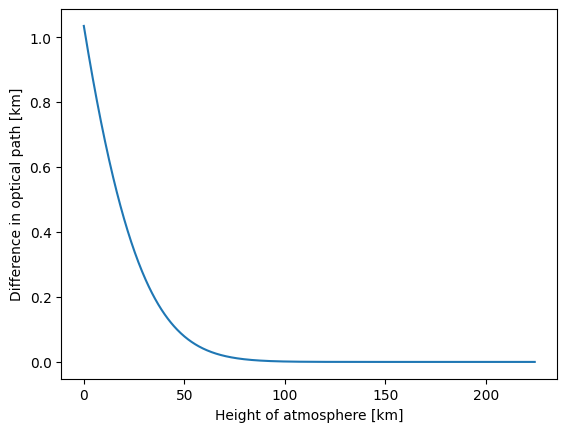

In [4]:
h_values = np.linspace(0, 2.2*np.max(R_datapoints), 1000)

plt.plot(h_values, calc_los_vectorized(h_values))
plt.xlabel("Height of atmosphere [km]")
plt.ylabel("Difference in optical path [km]")

## Visualizes the Change in optical path for difference heights of the atmosphere in 2d

In [ ]:
h_values = np.linspace(0, 2.2*np.max(R_datapoints), 64)
theta_values = np.linspace(0, 2*np.pi, 100)

h_values_grid, theta_values_grid = np.meshgrid(h_values, theta_values)

plt.subplot(projection='polar')
plt.pcolormesh(theta_values_grid, h_values_grid, calc_los_vectorized(h_values_grid))
plt.colorbar()